In [1]:
## Required Libraries

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score

In [2]:
## Refactored methods for file load and attribute conversion

def load_csv(csv_path):
    df = None
    try:
        df = pd.read_csv(csv_path)
    except Exception as e:
        print(e)

    return df


def convert_to_categories(df, col):
    df[col] = df[col]
    try:
        df[col] = pd.Categorical(df[col])
        print(df[col].cat.categories)
        df[col] = df[col].cat.codes
    except Exception as e:
        print(f"Unable to convert column {col} to cat codes...:{e}")

    return df[col]

def convert_to_bins(array_in, start, end, step):
    bins = None
    bin_range = range(start, end, step)
    label_range = range(start, (end - step), step)
    try:
        labels = [f"{x+1}s" for x in label_range]
        print(labels)
        bins = pd.cut(x=array_in, bins=bin_range, labels=labels)
    except Exception as e:
        print(e)

    return bins


In [3]:
## Createad a class here which includes methods related to dataset/dataframe manipulation

class DataHolder:
    def __init__(self, csv_path):
        self.csv_path = csv_path
        self.df = None
        self.model = None

    def dropna(self):
        df = self.df.dropna()
        return df

    def drop_cols(self, cols):
        for col in cols:
            try:
                self.df = self.df.drop([col], axis=1)
            except Exception as e:
                print(e)

    def load_data(self):
        self.df = load_csv(self.csv_path)

    def convert_data(self, cols, mode):
        if mode == 'cat':
            for col in cols:
                self.df[col] = convert_to_categories(df=self.df, col=col)
        elif mode == 'obj':
            print("not implemented yet")
        else:
            raise Exception("Select valid mode: ['cat']")

    def create_bins(self, col_in, col_out):
        self.df[col_out] = convert_to_bins(array_in=self.df[col_in], start=9, end=120, step=10)

    def train_model(self, mode, features, target):
        if mode == 'logistic_sklearn':
            self.model = train_logistic_sklearn(df=self.df, features=features, target=target)


In [4]:
## Methods to plot ans save graphs
GRAPH_DIR = './output/graphs/'


def graph_log_performance(df, name):
    sns.set(style='whitegrid')
    fig, ax = plt.subplots(figsize=(10, 5))
    df = df.sort_values(by='prob_1', ascending=True)
    df = df.reset_index()
    df['index_col'] = df.index
    # sns.scatterplot(data=df, x='index_col', y='prob_1')
    sns.lineplot(data=df, x='index_col', y='prob_1', ax=ax)
    sns.scatterplot(data=df, x='index_col', y='predictions', hue='correct_prediction',
                    palette={True: 'deepskyblue', False: 'tomato'}, ax=ax)
    ax.axhline(0.5, ls='--')
    ax.set_xlabel("Predictions", fontsize=14)
    ax.set_ylabel("Predicted Probability", fontsize=14)
    text_x = (len(df.index) * .8)
    ax.text(text_x, 0.75, "0: Negative Diagnosis\n 1: Positive Diagnosis", fontsize=11)

    sns.despine()

    save_path = f"{GRAPH_DIR}{name}.png"
    plt.savefig(save_path)


def graph_gender_performance(values, name, columns):
    sns.set(style='whitegrid')
    fig, ax = plt.subplots(figsize=(5, 5))

    remap_dict = {0: 'Female', 1: 'Male'}
    df = pd.DataFrame(values)
    df = df.reset_index()
    df.columns = columns
    df['Gender'] =  df['Gender'].map(remap_dict)
    print(type(values))
    print(df)

    sns.barplot(data=df, x='Gender', y='Count', palette=['tomato', 'tomato'])

    ax.set_xlabel("Gender", fontsize=14)
    ax.set_ylabel("Count", fontsize=14)
    text_x = (len(df.index) * .8)

    # ax.text(text_x, 0.75, "0: Negative Diagnosis\n 1: Positive Diagnosis", fontsize=11)

    sns.despine()

    save_path = f"{GRAPH_DIR}{name}.png"
    plt.savefig(save_path)





In [5]:
## building dataframe for model evaluation
def is_correct_prediction(prediction, observation):
    correct_prediction = None
    try:
        if prediction == observation:
            correct_prediction = True
        else:
            correct_prediction = False
    except Exception as e:
        print(e)
    return correct_prediction


def build_evaluation_df(prediction, probabilty, observed, features):
    """
    :param prediction: 1D array of model predictions
    :param probabilty: 2D array of prediction probability
    :param observed: 1D array of observed values
    :return:
    """
    df = None
    try:
        # print(features.head())
        # print(observed.head())
        features = features.copy()
        features['join_col'] = features.index
        df = pd.DataFrame(probabilty, columns=['prob_0', 'prob_1'])
        print(df.head())
        df['predictions'] = prediction
        df['observed'] = observed.tolist()
        df['correct_prediction'] = df[['predictions', 'observed']].apply(
            lambda x: is_correct_prediction(
                prediction=x['predictions'],
                observation=x['observed']),
            axis=1
        )
        df = df.copy()
        df['join_col'] = features.index
        df = df.merge(features, on=['join_col'])
        print(len(df.index))

    except Exception as e:
        print(e)

    return df


In [6]:
## Train Model

def train_logistic_sklearn(df, features, target):

    X = df[features]
    y = df[target]

    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.2,
        random_state=42
    )

    # First pass
    model = LogisticRegression(random_state=42)
    # Fit model
    model.fit(X_train, y_train)
    # Probability matrix of predicitons
    prob = model.predict_proba(X_test)
    # Model predictions
    prediction = model.predict(X_test)

    # Helper function to build dataframe used for graphing parts of model evaluation
    first_pass_evaluate_df = build_evaluation_df(prediction=prediction, probabilty=prob, observed=y_test, features=X_test)
    # Helpder function to generate graph to visualize model predictions
    graph_log_performance(df=first_pass_evaluate_df, name='first_pass_log')

    print(model.score(X_test, y_test))
    print(X_test.columns)
    print(model.coef_)
    print(prediction)
    print(first_pass_evaluate_df.head())

    print(f"Precision score: {precision_score(y_test, prediction)}")
    print(f"Accuracy score: {accuracy_score(y_test, prediction)}")
    print(f"Recall score: {recall_score(y_test, prediction)}")

    # Isolate incorrect cases
    incorrect_pred_df = first_pass_evaluate_df.loc[first_pass_evaluate_df['correct_prediction'] == False]
    print(incorrect_pred_df['Gender'].value_counts())


    correct_pred_df = first_pass_evaluate_df.loc[first_pass_evaluate_df['correct_prediction'] == True]

    cm = confusion_matrix(y_test, prediction)
    print(cm)

    print(incorrect_pred_df['Gender'].value_counts())
    print(correct_pred_df['Gender'].value_counts())

    graph_gender_performance(values=incorrect_pred_df['Gender'].value_counts(),
                             name='incorrect_predictions',
                             columns=['Gender', 'Count'])

    coefficients = list(model.coef_[0])
    inputs = X.columns
    coef_df = pd.DataFrame()
    coef_df['inputs'] = inputs
    coef_df['coef'] = coefficients
    coef_df = coef_df.sort_values(by='coef', ascending=False)
    print(coef_df)

    exit()

    # FUTURE REFINEMENTS...
    # SMOTE
    columns = X_train.columns
    oversample = SMOTE(random_state=42)
    oversample_X, oversample_y = oversample.fit_resample(X_train, y_train)
    oversample_X_df = pd.DataFrame(oversample_X, columns=columns)
    oversample_y_df = pd.DataFrame(oversample_y, columns=[target])

    # Create model
    model = LogisticRegression(random_state=42)
    # Recursive feature selection
    rfe = RFE(model, 10)
    # Fit th emodel
    rfe.fit(X_train, y_train.values.ravel())
    print(rfe.support_)
    print(rfe.ranking_)

    # Model stats
    logit_model = sm.Logit(y, X)
    result = logit_model.fit()
    print(result.summary2())

    # Select columns from RFE
    mask = list(rfe.get_support())
    new_features = X.columns[mask]
    print(f"New features: {new_features}")

    # Fit model with new features
    X = df[new_features]
    # Model stats with new feautures
    logit_model = sm.Logit(y, X)
    result = logit_model.fit()
    print(result.summary2())

    print(type(new_features))
    zip_cols_mask = zip(X.columns, mask)

    # Only select column names where mask is True
    new_cols = [i for i, j in zip_cols_mask if j]

    new_cols.remove('delayed healing')
    new_features = X[new_cols].columns
    print(f"New features 2: {new_features}")

    # Fit model with new features minus >0.5 P
    X = df[new_features]
    # Model stats with new feautures
    logit_model = sm.Logit(y, X)
    result = logit_model.fit()
    print(result.summary2())

Index(['Female', 'Male'], dtype='object')
Index(['No', 'Yes'], dtype='object')
Index(['No', 'Yes'], dtype='object')
Index(['No', 'Yes'], dtype='object')
Index(['No', 'Yes'], dtype='object')
Index(['No', 'Yes'], dtype='object')
Index(['No', 'Yes'], dtype='object')
Index(['No', 'Yes'], dtype='object')
Index(['No', 'Yes'], dtype='object')
Index(['No', 'Yes'], dtype='object')
Index(['No', 'Yes'], dtype='object')
Index(['No', 'Yes'], dtype='object')
Index(['No', 'Yes'], dtype='object')
Index(['No', 'Yes'], dtype='object')
Index(['No', 'Yes'], dtype='object')
Index(['Negative', 'Positive'], dtype='object')
['10s', '20s', '30s', '40s', '50s', '60s', '70s', '80s', '90s', '100s', '110s']
Index(['10s', '20s', '30s', '40s', '50s', '60s', '70s', '80s', '90s', '100s',
       '110s'],
      dtype='object')
    Gender  Polyuria  Polydipsia  sudden weight loss  weakness  Polyphagia  \
0        1         0           1                   0         1           0   
1        1         0           0        

FileNotFoundError: [Errno 2] No such file or directory: './output/graphs/first_pass_log.png'

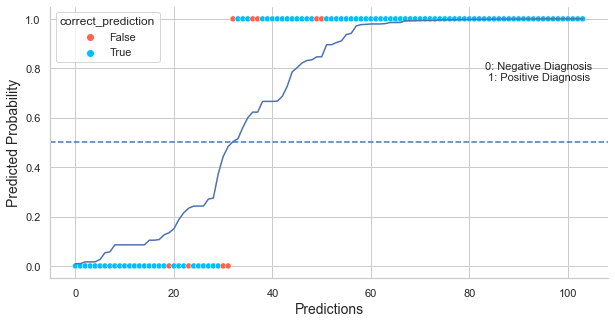

In [7]:
def main(csvpath):
    dia_data = DataHolder(csv_path=csvpath)
    dia_data.load_data()

    # Convert object cols to categorical cols
    cols_to_convert = dia_data.df.select_dtypes(include='object').columns.tolist()
    dia_data.convert_data(cols=cols_to_convert, mode='cat')

    # Convert age into age groups
    dia_data.create_bins(col_in='Age', col_out='age_bin')
    dia_data.convert_data(cols=['age_bin'], mode='cat')

    # Drop original age column
    cols_to_drop = ['Age']
    dia_data.drop_cols(cols=cols_to_drop)

    print(dia_data.df.head(15))

    # Train model
    target = 'class'
    features = dia_data.df.columns.tolist()
    features.remove(target)

    dia_data.train_model(mode='logistic_sklearn', features=features, target=target)


if __name__ == '__main__':
    csv_path = 'diabetes_data_upload.csv'
    main(csvpath=csv_path)